In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("ag_news", split="train")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

## Examine the dataset

In [6]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
Court Rejects Child Porn Internet Law A federal court Friday struck down as unconstitutional a path-breaking Pennsylvania law designed to prevent Internet users from seeing Web sites that contain child pornography.

Sample 2
Manchester United manager wants to get to the bottom of  #39;Soupgate #39; Manchester United manager Sir Alex Ferguson wants to get the bottom of the  quot;Soupgate quot; affair. Ferguson was forced to change clothes after United #39;s 2-0 victory Sunday over Arsenal.

Sample 3
'Distribution System Is Not Working' A week into one of  South Asia's most devastating disasters in history, an international campaign to help Indonesia recover has at last moved into gear. But from the airport on, the distribution system slapped together has proved spotty at best.

Sample 4
Thompson Resigns from East Carolina Post  GREENVILLE, N.C. (Sports Network) - East Carolina head  football coach John Thompson announced his resignation,  effective at the end of the season, on 

In [7]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

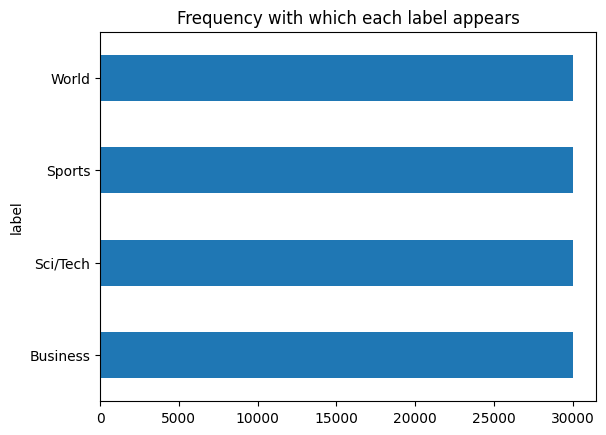

In [10]:
(
    dataset.select_columns('label')
        .to_pandas()
        .astype(str)['label']
        .map(id2label)
        .value_counts()
        .plot(kind="barh", title="Frequency with which each label appears")
);